In [1]:
!pip install xgboost
!pip install shap
!pip install explainerdashboard
!pip install --upgrade fairlearn==0.7.0 raiwidgets

# Dateset:
- https://www.kaggle.com/saniyajaswani/credit-card-data

In [2]:
# import all modules
from pathlib import Path
from google.colab import drive

import pandas as pd #we use this to load, read and transform the dataset
import numpy as np #we use this for statistical analysis
import matplotlib.pyplot as plt #we use this to visualize the dataset

import seaborn as sns #we use this to make countplots
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder # scale numeric features
from sklearn.model_selection import train_test_split # train test split data

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import metrics

import shap

from explainerdashboard import RegressionExplainer, ExplainerDashboard

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`


In [3]:
# let´s mount the some folders for e.g. training data and models etc.
drive.mount('/content/gdrive')

# create data and model folders
MODELPATH = "gdrive/MyDrive/Responsible_AI/Customer_LifeTime_Value/models"
DATAPATH = "gdrive/MyDrive/Responsible_AI/Customer_LifeTime_Value/data"
DASHBOARDPATH = "gdrive/MyDrive/Responsible_AI/Customer_LifeTime_Value/dashboard"

Path(MODELPATH).mkdir(parents=True, exist_ok=True)
Path(DATAPATH).mkdir(parents=True, exist_ok=True)
Path(DASHBOARDPATH).mkdir(parents=True, exist_ok=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
df = pd.read_csv(DATAPATH / Path('cltv_bank.csv'))
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [5]:
# is the customer id unique?
print('df got {} datasets'.format(df.shape[0]))
print('df got {} unique customers'.format(df.Customer.unique().shape[0]))

df got 9134 datasets
df got 9134 unique customers


In [6]:
# check missing values
df.isnull().sum()

Customer                         0
State                            0
Customer Lifetime Value          0
Response                         0
Coverage                         0
Education                        0
Effective To Date                0
EmploymentStatus                 0
Gender                           0
Income                           0
Location Code                    0
Marital Status                   0
Monthly Premium Auto             0
Months Since Last Claim          0
Months Since Policy Inception    0
Number of Open Complaints        0
Number of Policies               0
Policy Type                      0
Policy                           0
Renew Offer Type                 0
Sales Channel                    0
Total Claim Amount               0
Vehicle Class                    0
Vehicle Size                     0
dtype: int64

In [7]:
# what type of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

# Define Feature Types and Target

In [8]:
target = ['Customer Lifetime Value']

numeric_features = ['Income', 
                    'Monthly Premium Auto', 
                    'Months Since Last Claim', 
                    'Months Since Policy Inception', 
                    'Number of Open Complaints', 
                    'Number of Policies', 
                    'Total Claim Amount']

cat_features = ['State', 'Response', 'Coverage', 'Education', 'EmploymentStatus', 
                'Policy Type', 'Policy', 'Renew Offer Type', 'Sales Channel', 'Vehicle Class', 'Vehicle Size',
                'Gender', 'Marital Status', 'Location Code']

sensitive_features = ['Gender', 'Marital Status'] # we try to avoid any unfair model behavior along gender, marital status or location code

In [9]:
# reorder columns
df = df[numeric_features + cat_features + target]


In [10]:
df.head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State,Response,Coverage,...,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Gender,Marital Status,Location Code,Customer Lifetime Value
0,56274,69,32,5,0,1,384.811147,Washington,No,Basic,...,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban,2763.519279
1,0,94,13,42,0,8,1131.464935,Arizona,No,Extended,...,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize,F,Single,Suburban,6979.535903
2,48767,108,18,38,0,2,566.472247,Nevada,No,Premium,...,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban,12887.431650
3,0,106,18,65,0,7,529.881344,California,No,Basic,...,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize,M,Married,Suburban,7645.861827
4,43836,73,12,44,0,1,138.130879,Washington,No,Basic,...,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize,M,Single,Rural,2813.692575


# Lets do EDA on numeric features first

In [11]:
df[numeric_features].head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
0,56274,69,32,5,0,1,384.811147
1,0,94,13,42,0,8,1131.464935
2,48767,108,18,38,0,2,566.472247
3,0,106,18,65,0,7,529.881344
4,43836,73,12,44,0,1,138.130879


In [12]:
# descriptive statistics for numeric data
df.describe()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Customer Lifetime Value
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794,8004.940475
std,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092,6870.967608
min,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007,1898.007675
25%,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244,3994.251794
50%,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434,5780.182197
75%,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839,8962.167041
max,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678,83325.381190


In [13]:
# what about person correlation?
df[target + numeric_features].corr()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
Customer Lifetime Value,1.000000,0.024366,0.396262,0.011517,0.009418,-0.036343,0.021955,0.226451
Income,0.024366,1.000000,-0.016665,-0.026715,-0.000875,0.006408,-0.008656,-0.355254
Monthly Premium Auto,0.396262,-0.016665,1.000000,0.005026,0.020257,-0.013122,-0.011233,0.632017
Months Since Last Claim,0.011517,-0.026715,0.005026,1.000000,-0.042959,0.005354,0.009136,0.007563
Months Since Policy Inception,0.009418,-0.000875,0.020257,-0.042959,1.000000,-0.001158,-0.013333,0.003335
Number of Open Complaints,-0.036343,0.006408,-0.013122,0.005354,-0.001158,1.000000,0.001498,-0.014241
Number of Policies,0.021955,-0.008656,-0.011233,0.009136,-0.013333,0.001498,1.000000,-0.002354
Total Claim Amount,0.226451,-0.355254,0.632017,0.007563,0.003335,-0.014241,-0.002354,1.000000


Apparently we see some noticeable correlation between CLV, monthly premium auto and total claim amount

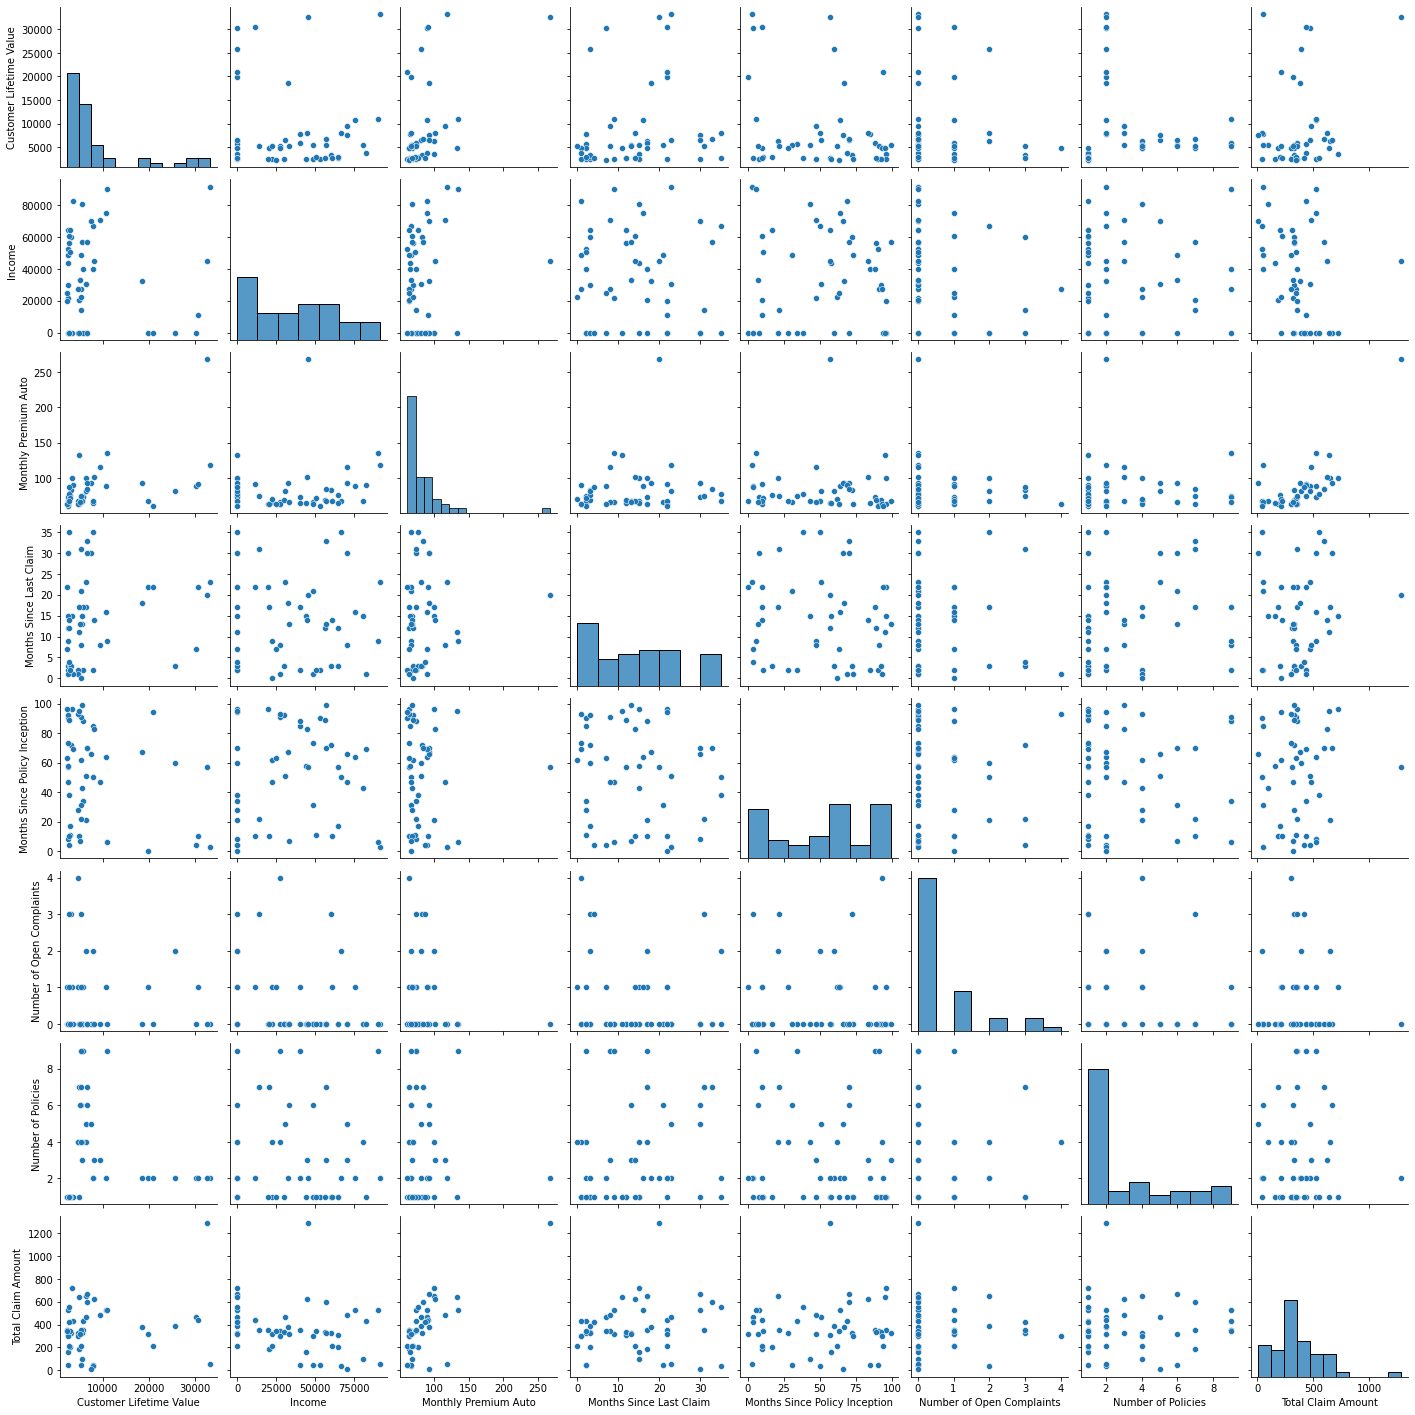

In [14]:
# lets have a look
sns.pairplot(df[target + numeric_features].sample(50))
plt.show()

so far, the chances are pretty low that we get some good CLV prediction by using the weakly correlated numeric data only (which I was hoping :-) )
so let´s go about the categorical data and hope for something good to happen ;-)

# Lets do EDA on categorical features

In [15]:
df[target + cat_features].head()

,Customer Lifetime Value,State,Response,Coverage,Education,EmploymentStatus,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Gender,Marital Status,Location Code
0,2763.519279,Washington,No,Basic,Bachelor,Employed,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban
1,6979.535903,Arizona,No,Extended,Bachelor,Unemployed,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize,F,Single,Suburban
2,12887.431650,Nevada,No,Premium,Bachelor,Employed,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban
3,7645.861827,California,No,Basic,Bachelor,Unemployed,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize,M,Married,Suburban
4,2813.692575,Washington,No,Basic,Bachelor,Employed,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize,M,Single,Rural


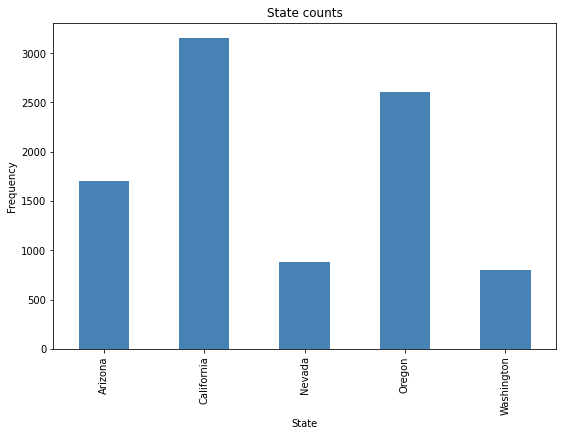

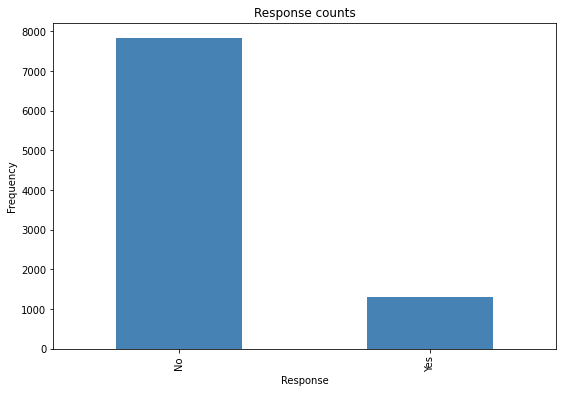

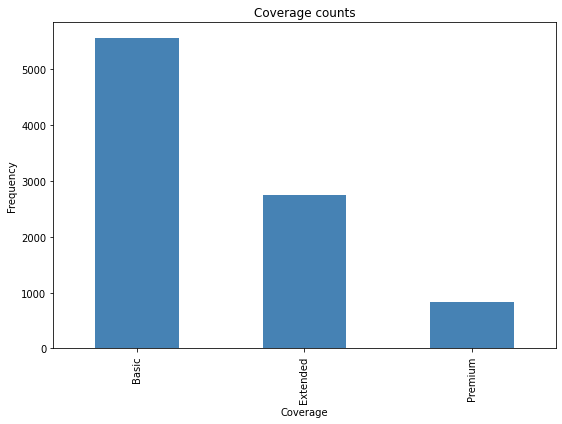

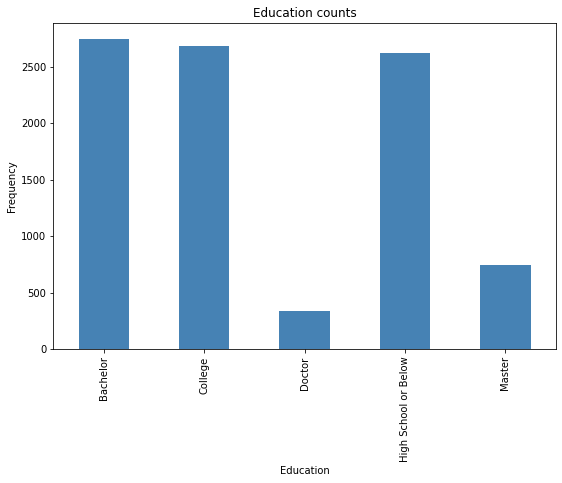

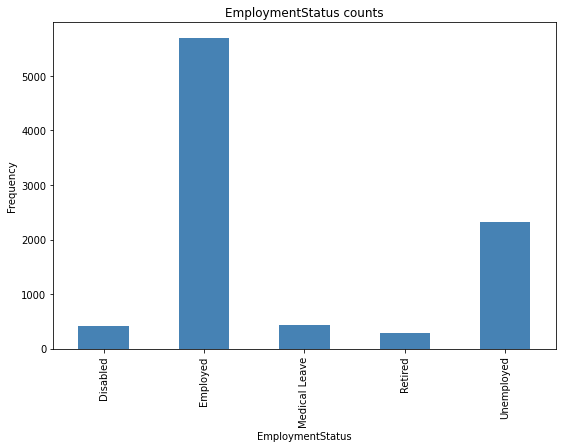

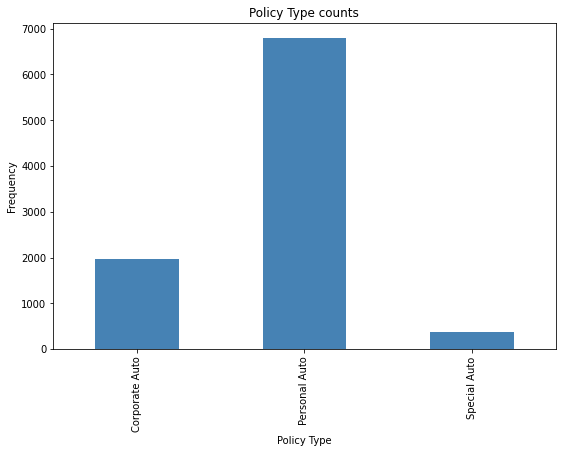

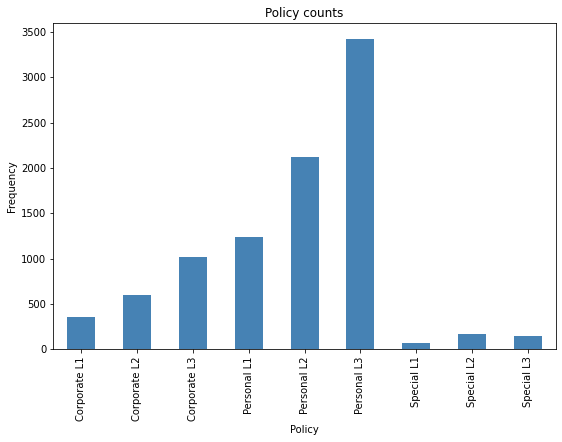

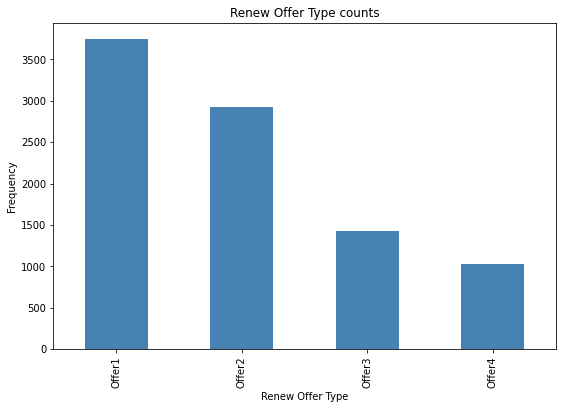

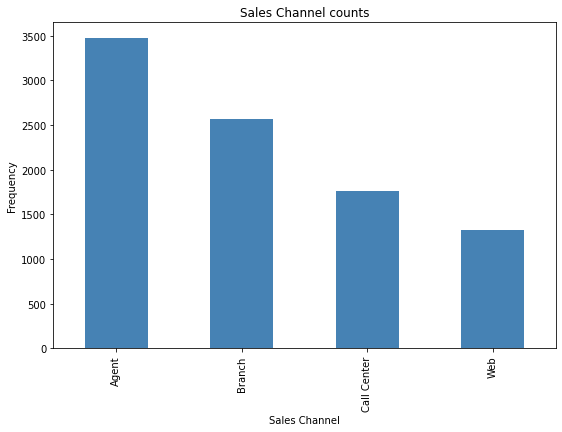

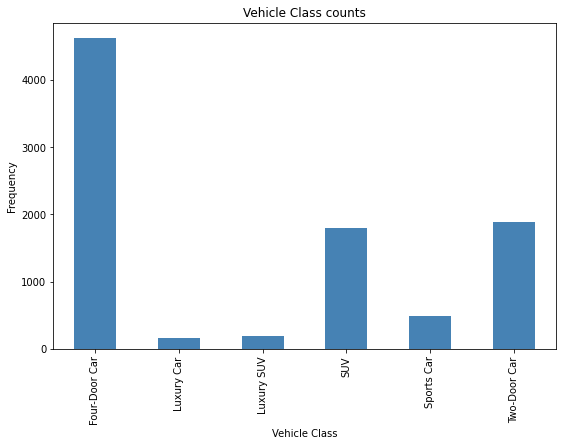

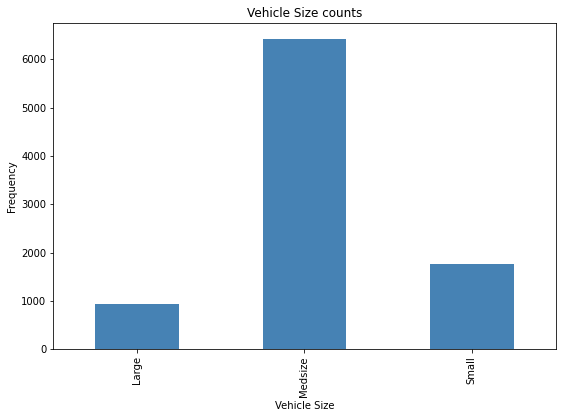

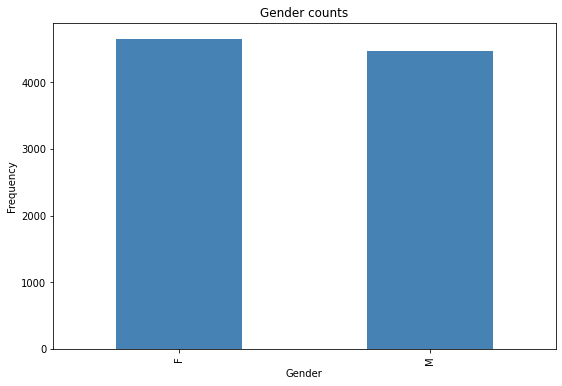

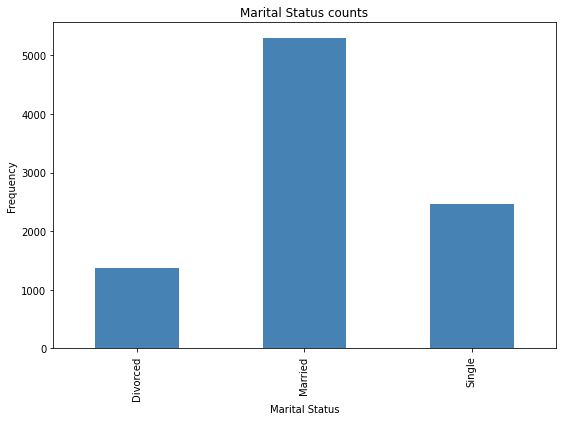

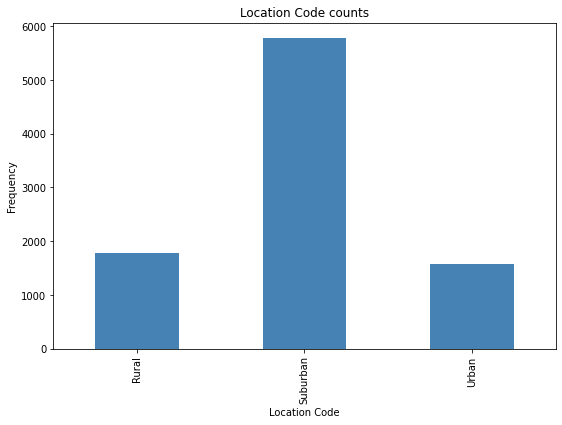

In [16]:
# plot a bar plot for each categorical feature count
for col in cat_features:
    counts = df[col].value_counts().sort_index()
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    counts.plot.bar(ax = ax, color='steelblue')
    ax.set_title(col + ' counts')
    ax.set_xlabel(col) 
    ax.set_ylabel("Frequency")
plt.show()

With respect to the sensitive feature employment status, we dont want e.g. disabled people to be scored unfairly. With respect to the sensitive feature gender, we dont want male, female to be scored differently etc..

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


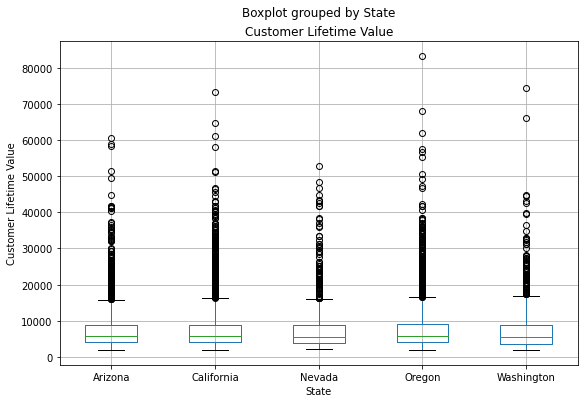

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


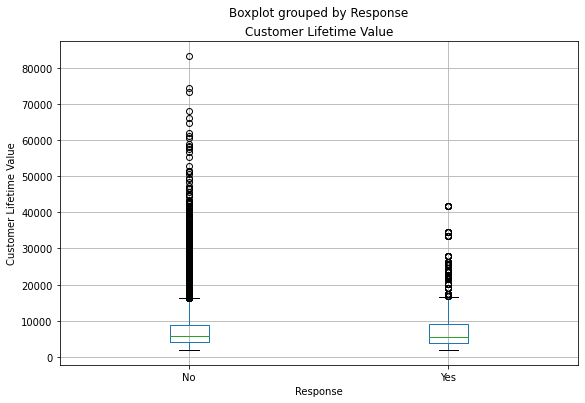

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


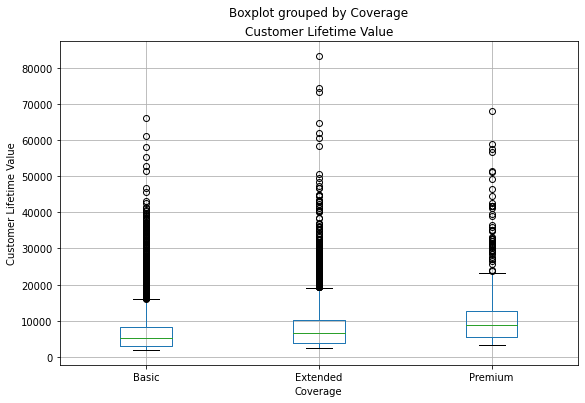

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


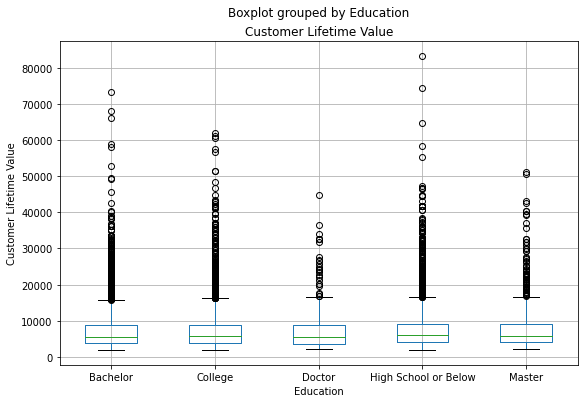

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


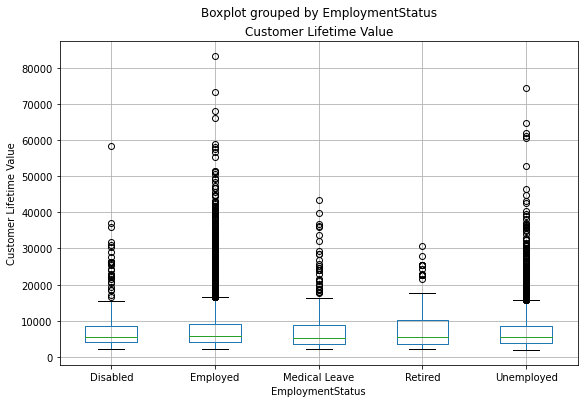

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


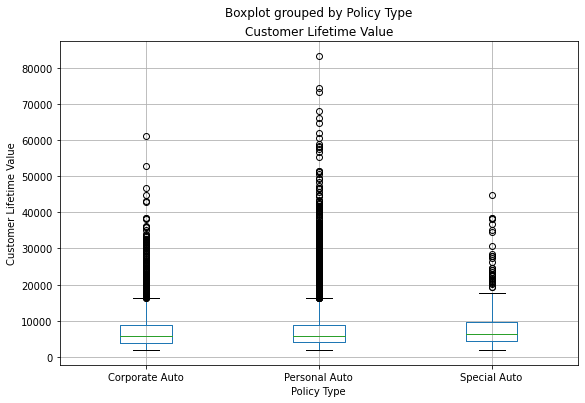

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


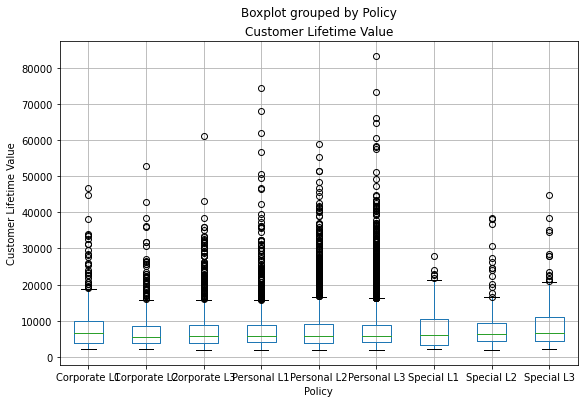

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


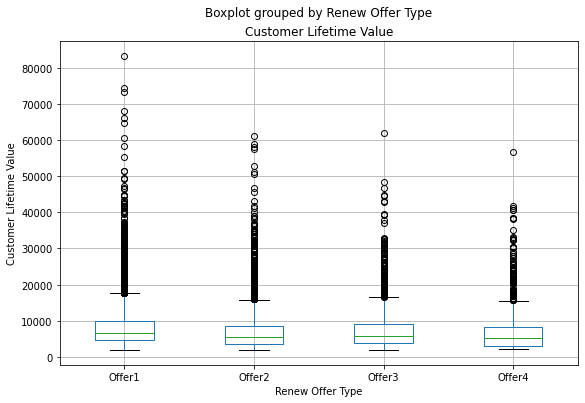

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


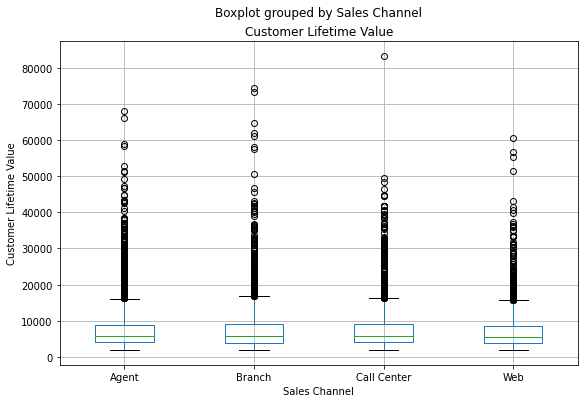

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


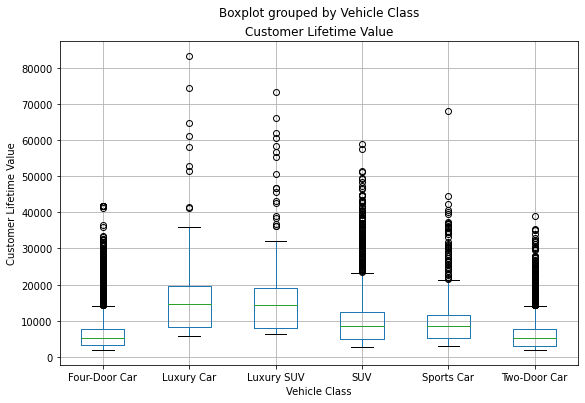

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


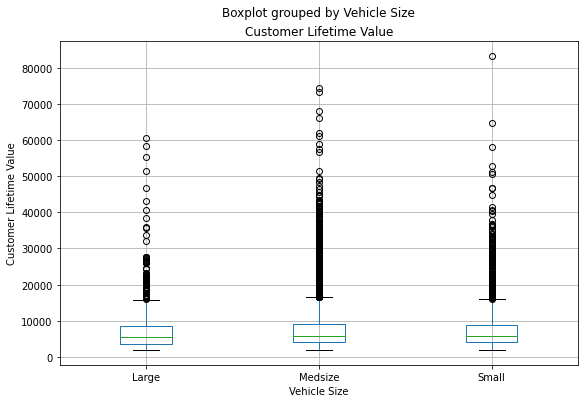

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


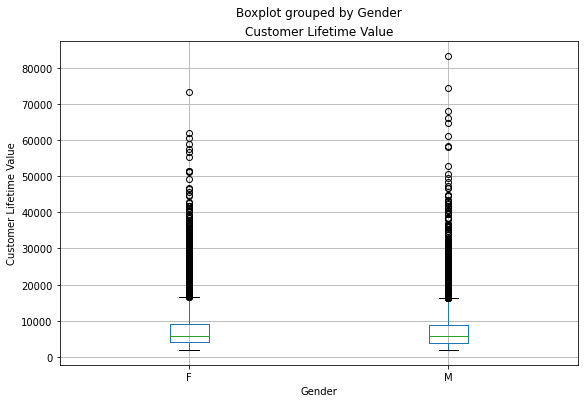

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


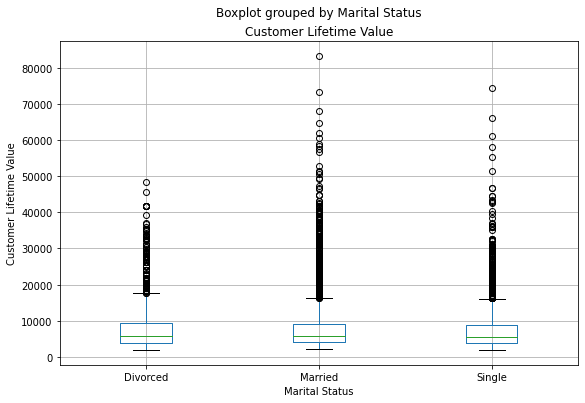

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


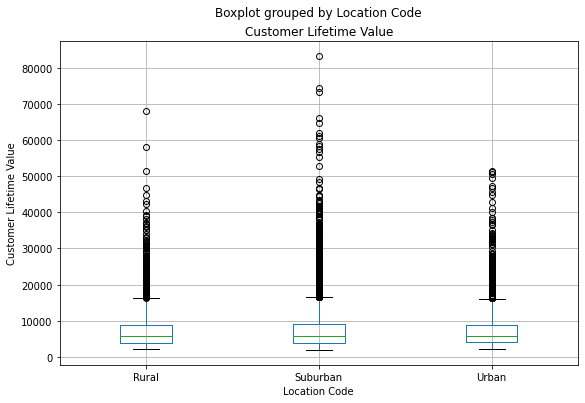

In [17]:
# plot a boxplot for the label by each categorical feature
for feat in cat_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    df.boxplot(column='Customer Lifetime Value', by = feat, ax = ax)
    ax.set_ylabel("Customer Lifetime Value")
    plt.show()

With respect to the features "coverage" and "vehicle class", we see some apparent effect on CLV.

# Train-Test Split

In [18]:
df.head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State,Response,Coverage,...,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Gender,Marital Status,Location Code,Customer Lifetime Value
0,56274,69,32,5,0,1,384.811147,Washington,No,Basic,...,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban,2763.519279
1,0,94,13,42,0,8,1131.464935,Arizona,No,Extended,...,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize,F,Single,Suburban,6979.535903
2,48767,108,18,38,0,2,566.472247,Nevada,No,Premium,...,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban,12887.431650
3,0,106,18,65,0,7,529.881344,California,No,Basic,...,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize,M,Married,Suburban,7645.861827
4,43836,73,12,44,0,1,138.130879,Washington,No,Basic,...,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize,M,Single,Rural,2813.692575


In [19]:
# Separate features and labels
X, y = df[numeric_features + cat_features], df[target].values
print('Features:',X[:3], '\nLabels:', y[:3], sep='\n')

Features:
   Income  Monthly Premium Auto  Months Since Last Claim  \
0   56274                    69                       32   
1       0                    94                       13   
2   48767                   108                       18   

   Months Since Policy Inception  Number of Open Complaints  \
0                              5                          0   
1                             42                          0   
2                             38                          0   

   Number of Policies  Total Claim Amount       State Response  Coverage  ...  \
0                   1          384.811147  Washington       No     Basic  ...   
1                   8         1131.464935     Arizona       No  Extended  ...   
2                   2          566.472247      Nevada       No   Premium  ...   

  EmploymentStatus     Policy Type        Policy Renew Offer Type  \
0         Employed  Corporate Auto  Corporate L3           Offer1   
1       Unemployed   Personal Aut

In [20]:
# Split data into training set and test set
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(X, y, df, test_size=0.40, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 5480 rows
Test Set: 3654 rows


## Scale Numeric Data

In [21]:
# scale numeric features
scaler = RobustScaler(quantile_range=(10,90))
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_train.head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State,Response,Coverage,...,EmploymentStatus,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Gender,Marital Status,Location Code
925,-0.094889,0.484848,-0.142857,-0.233766,0.0,0.166667,0.252806,California,No,Basic,...,Employed,Corporate Auto,Corporate L3,Offer3,Web,SUV,Medsize,F,Married,Suburban
2830,0.796756,0.590909,-0.035714,0.610390,0.0,0.166667,-0.157252,Nevada,No,Extended,...,Employed,Personal Auto,Personal L3,Offer3,Call Center,SUV,Medsize,F,Married,Rural
3109,-0.289044,-0.227273,0.071429,0.103896,0.0,0.000000,-0.084312,Oregon,No,Basic,...,Retired,Personal Auto,Personal L3,Offer2,Branch,Four-Door Car,Small,F,Married,Suburban
3609,-0.206719,-0.303030,-0.250000,-0.038961,0.0,0.000000,-0.120175,Nevada,No,Basic,...,Disabled,Personal Auto,Personal L3,Offer2,Agent,Two-Door Car,Medsize,M,Married,Suburban
5570,0.060632,0.257576,0.714286,-0.311688,0.0,-0.166667,-0.315072,Oregon,No,Extended,...,Employed,Personal Auto,Personal L3,Offer3,Branch,Four-Door Car,Medsize,M,Married,Rural


# Label-Encoding Categorical Data


In [22]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [23]:
# init encoder
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1000)
# fit encoder
enc.fit(X_train[cat_features])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1000)

In [24]:
# transform data
X_train[cat_features] = enc.transform(X_train[cat_features])
X_train.head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State,Response,Coverage,...,EmploymentStatus,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Gender,Marital Status,Location Code
925,-0.094889,0.484848,-0.142857,-0.233766,0.0,0.166667,0.252806,1.0,0.0,0.0,...,1.0,0.0,2.0,2.0,3.0,3.0,1.0,0.0,1.0,1.0
2830,0.796756,0.590909,-0.035714,0.610390,0.0,0.166667,-0.157252,2.0,0.0,1.0,...,1.0,1.0,5.0,2.0,2.0,3.0,1.0,0.0,1.0,0.0
3109,-0.289044,-0.227273,0.071429,0.103896,0.0,0.000000,-0.084312,3.0,0.0,0.0,...,3.0,1.0,5.0,1.0,1.0,0.0,2.0,0.0,1.0,1.0
3609,-0.206719,-0.303030,-0.250000,-0.038961,0.0,0.000000,-0.120175,2.0,0.0,0.0,...,0.0,1.0,5.0,1.0,0.0,5.0,1.0,1.0,1.0,1.0
5570,0.060632,0.257576,0.714286,-0.311688,0.0,-0.166667,-0.315072,3.0,0.0,1.0,...,1.0,1.0,5.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0


# Transform Hold-Out Dataset

In [25]:
# scale numeric data
X_test[numeric_features] = scaler.transform(X_test[numeric_features])
# transform data
X_test[cat_features] = enc.transform(X_test[cat_features])
X_test.head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State,Response,Coverage,...,EmploymentStatus,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Gender,Marital Status,Location Code
2182,0.341792,-0.181818,-0.035714,-0.285714,0.0,0.500000,-0.062794,1.0,0.0,0.0,...,1.0,1.0,4.0,2.0,0.0,5.0,1.0,0.0,0.0,1.0
7823,-0.414707,-0.212121,-0.142857,0.428571,0.0,-0.166667,0.166734,3.0,0.0,0.0,...,4.0,0.0,1.0,0.0,2.0,5.0,1.0,0.0,2.0,1.0
1651,0.233864,0.560606,-0.357143,-0.532468,0.0,0.666667,0.288670,4.0,0.0,2.0,...,1.0,1.0,5.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0
888,-0.078101,2.378788,-0.500000,0.311688,2.0,-0.166667,3.758537,0.0,0.0,1.0,...,2.0,1.0,4.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0
3844,-0.414707,0.666667,0.035714,-0.038961,0.0,-0.166667,0.790761,4.0,0.0,1.0,...,4.0,1.0,3.0,3.0,0.0,3.0,2.0,1.0,2.0,1.0


# Model Selection: LightGBM vs Boosted Tree

In [26]:
lgb_model = LGBMRegressor().fit(X_train, y_train.reshape(-1))
print (lgb_model)

LGBMRegressor()


MSE: 15324938.550939523
RMSE: 3914.7079777346767
R2: 0.6803397650841843


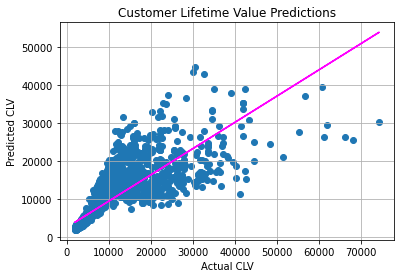

In [27]:
# Evaluate Model
predictions = lgb_model.predict(X_test).reshape(-1)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Customer Lifetime Value Predictions')

# overlay the regression line
z = np.polyfit(y_test.reshape(-1), predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.grid('on')
plt.show()

In [28]:
# Train XGB model
xgb_model = XGBRegressor().fit(X_train, y_train)
print (xgb_model)

[09:54:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor()


MSE: 15322665.698393533
RMSE: 3914.417670406868
R2: 0.680387174121184


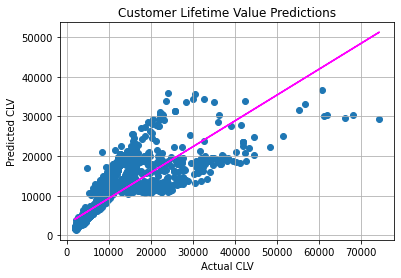

In [29]:
# Evaluate Model
predictions = xgb_model.predict(X_test).reshape(-1)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Customer Lifetime Value Predictions')

# overlay the regression line
z = np.polyfit(y_test.reshape(-1), predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.grid('on')
plt.show()


# Tune Best Model

In [30]:
# tune these hyperparameters
params = {
 'num_leaves': [20, 30, 40],
 'n_estimators' : [50, 100, 200]
 }

In [31]:
# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(lgb_model, 
                          params, 
                          scoring=score, cv=3, 
                          return_train_score=True)
gridsearch.fit(X_train, y_train.reshape(-1))
print("Best parameter combination:", gridsearch.best_params_, "\n")

Best parameter combination: {'n_estimators': 50, 'num_leaves': 30} 



In [32]:
# get tuned model
tuned_model = gridsearch.best_estimator_
print(tuned_model, "\n")

LGBMRegressor(n_estimators=50, num_leaves=30) 



In [33]:
# Evaluate the model using the test data
predictions = tuned_model.predict(X_test).reshape(-1)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

MSE: 14816196.201235123
RMSE: 3849.181237774486
R2: 0.6909515335084148


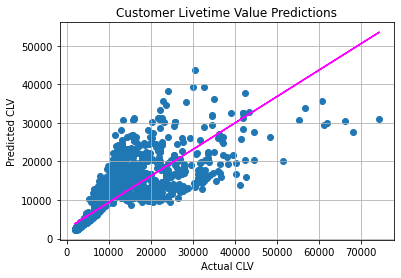

In [34]:
# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Customer Livetime Value Predictions')

# overlay the regression line
z = np.polyfit(y_test.reshape(-1), predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.grid('on')
plt.show()

# Explain Model

In [35]:
print(tuned_model)

LGBMRegressor(n_estimators=50, num_leaves=30)


In [36]:
# get feature names
feature_names = list(X_train.columns)
# init Tree explainer
explainer = shap.TreeExplainer(tuned_model, X_test)
# get shapley values
shap_values = explainer(X_test, check_additivity=False)

## init Partition Explainer
#explainer = shap.PartitionExplainer(model.predict, X_test)
## get shapley values
#shap_values = explainer(X_test)

## Global Model Explanation

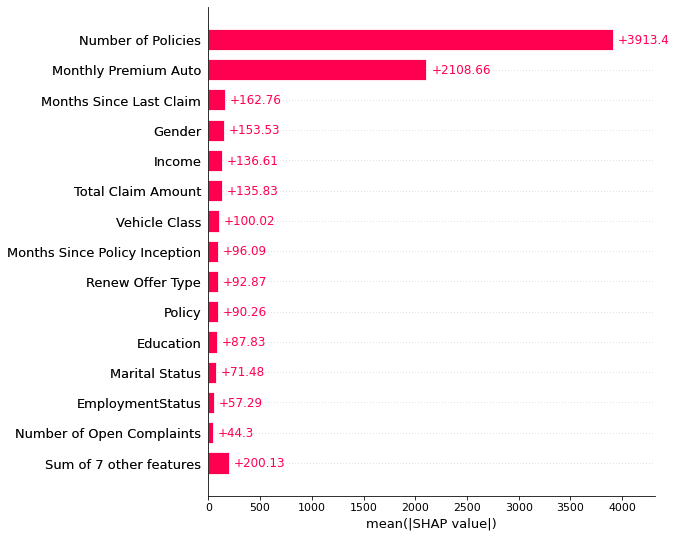

In [37]:
shap.plots.bar(shap_values, max_display=15)

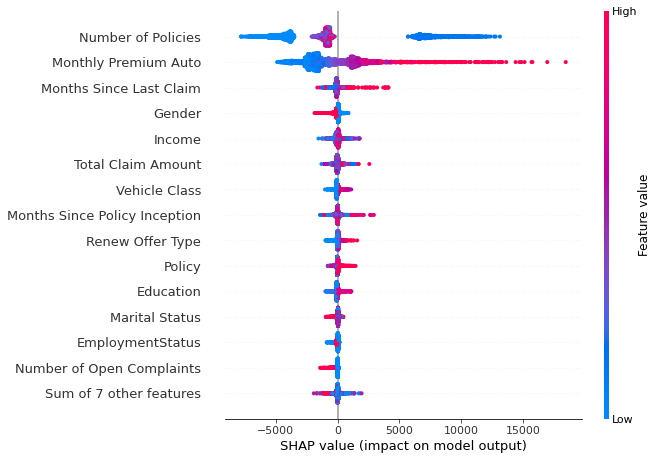

In [38]:
shap.plots.beeswarm(shap_values, max_display=15)

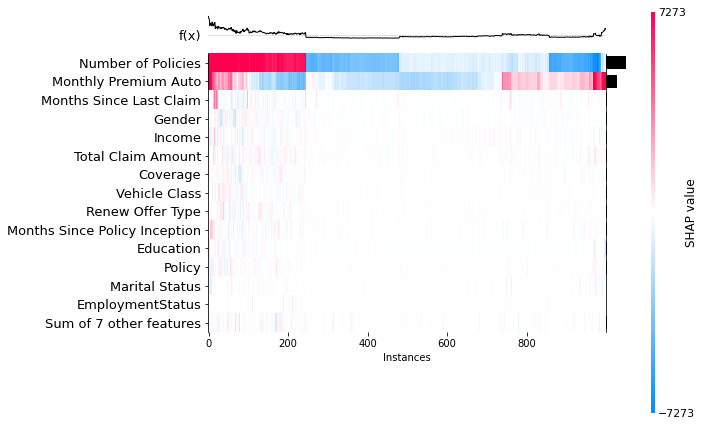

In [39]:
shap.plots.heatmap(shap_values[0:1000], max_display=15)

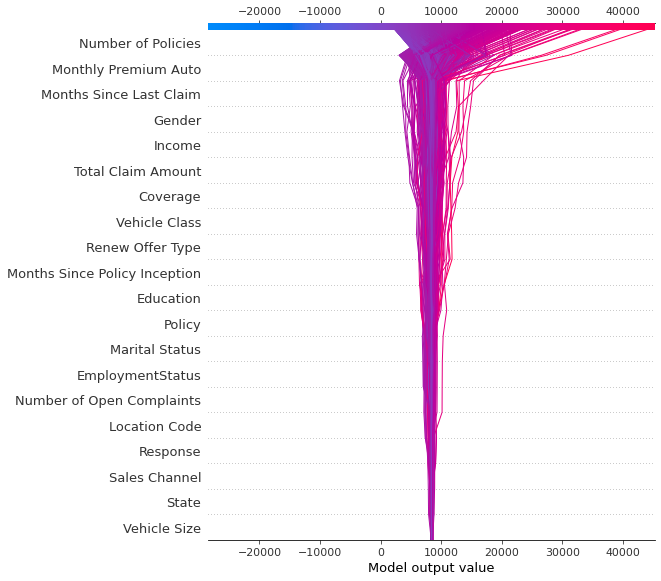

In [40]:
X_test_invtrans = X_test.copy()
X_test_invtrans[cat_features] = enc.inverse_transform(X_test_invtrans[cat_features])
X_test_invtrans[numeric_features] = scaler.inverse_transform(X_test_invtrans[numeric_features])

shap.decision_plot(base_value=shap_values.base_values[0], 
                   shap_values= shap_values.values[0:1000],
                   features = X_test_invtrans[0:1000],
                   ignore_warnings=True)

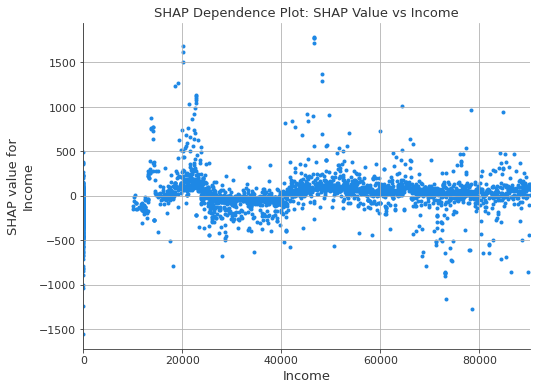

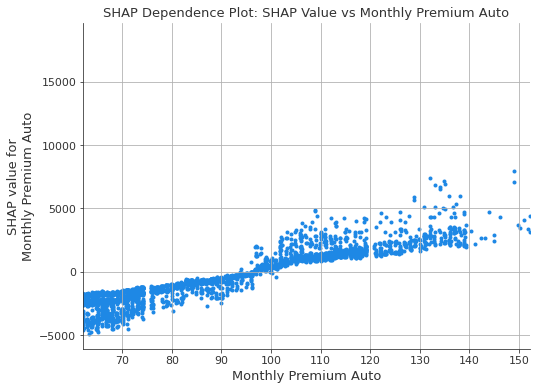

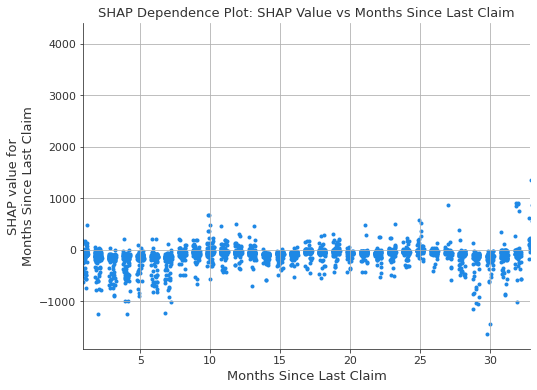

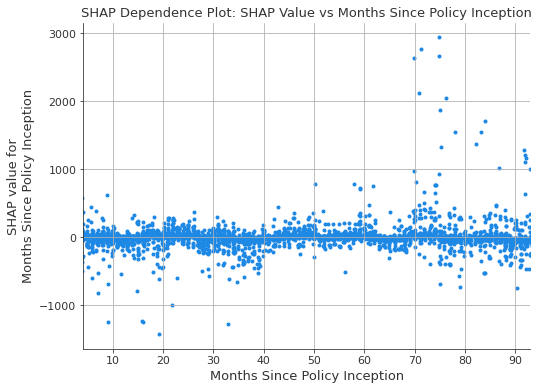

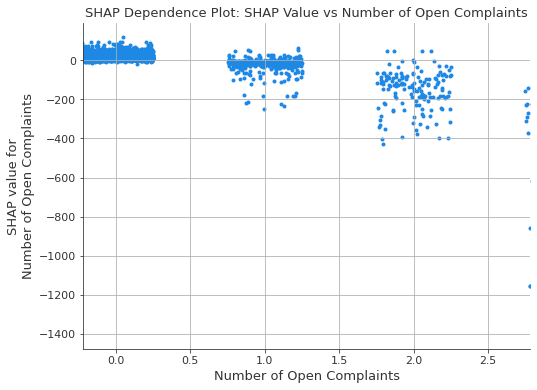

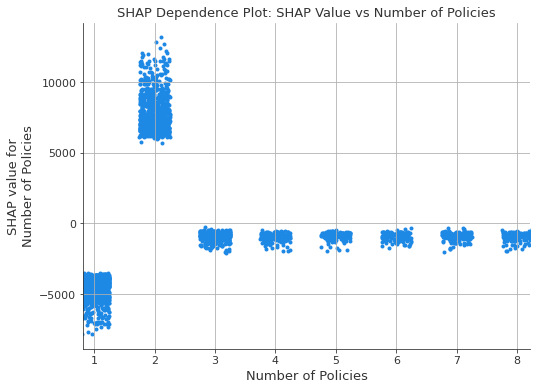

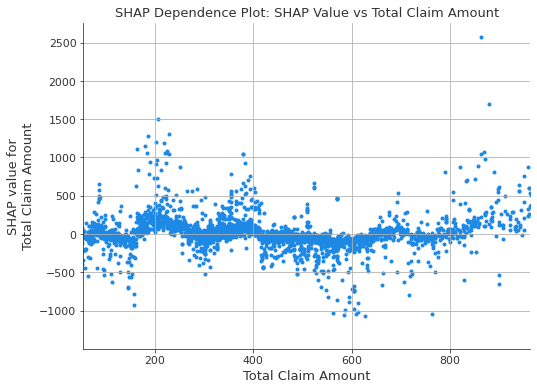

In [41]:
# show shap dependence plot for numeric features
X_test_invtrans = X_test.copy()
X_test_invtrans[cat_features] = enc.inverse_transform(X_test_invtrans[cat_features])
X_test_invtrans[numeric_features] = scaler.inverse_transform(X_test_invtrans[numeric_features])

for nf in numeric_features:
  fig = plt.figure(figsize=(8, 6))
  ax = fig.gca()
  shap.dependence_plot(nf, 
                      shap_values = shap_values.values, 
                      features = X_test_invtrans,
                      x_jitter = 0.5,
                      xmin="percentile(5.0)",
                      xmax="percentile(95.0)", 
                      interaction_index=None,
                      title = 'SHAP Dependence Plot: SHAP Value vs {}'.format(nf),
                      ax=ax,
                      show=False)
  ax.grid('on')

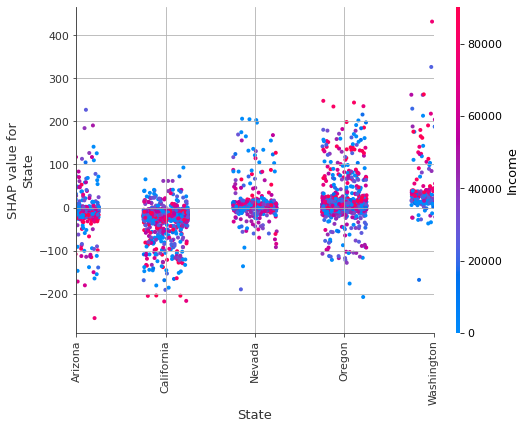

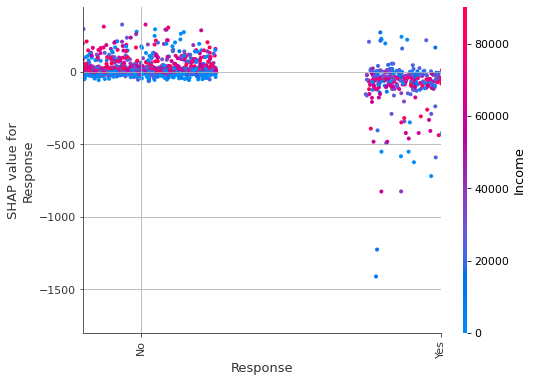

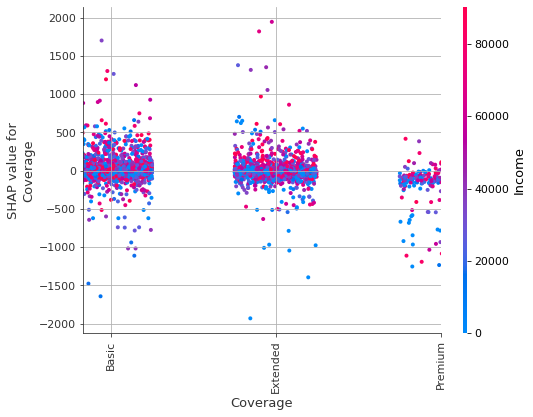

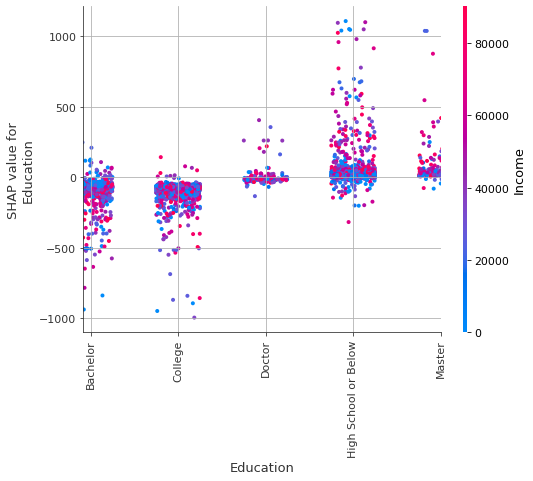

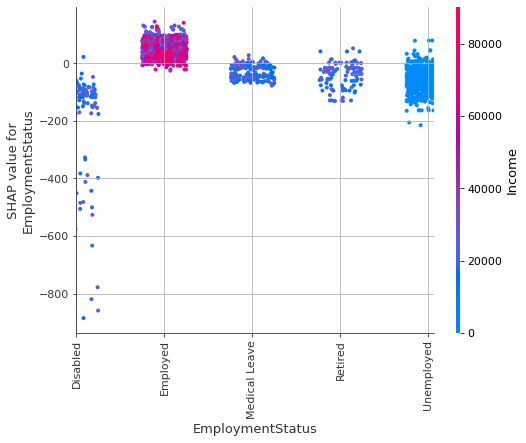

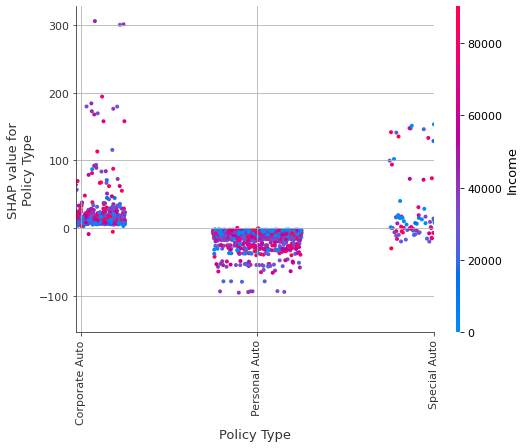

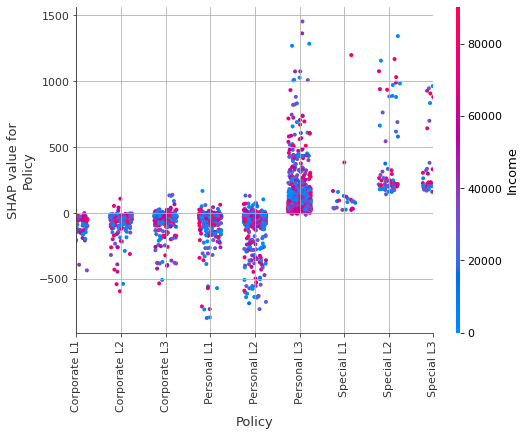

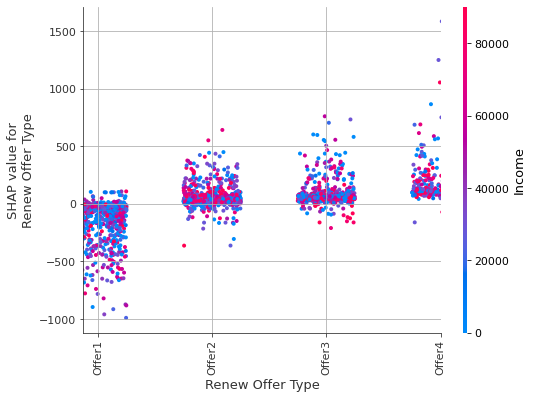

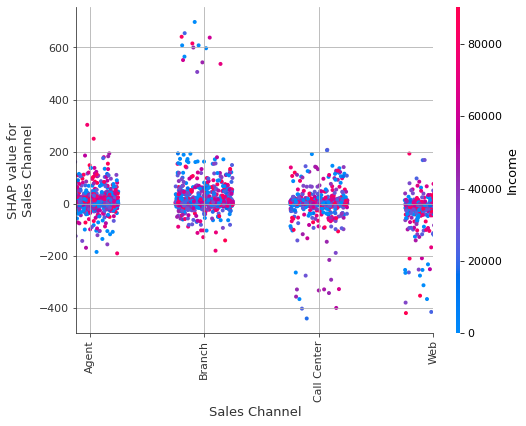

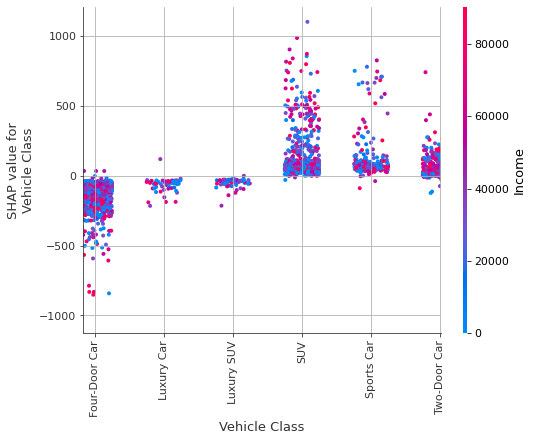

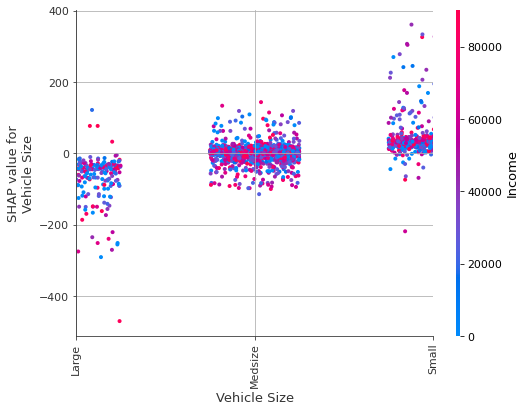

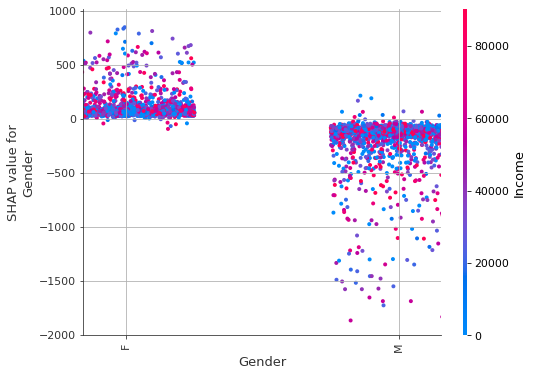

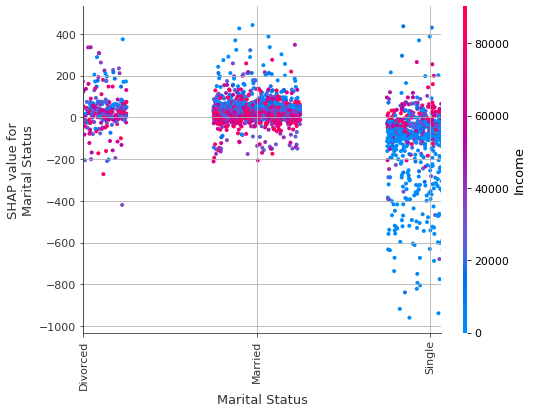

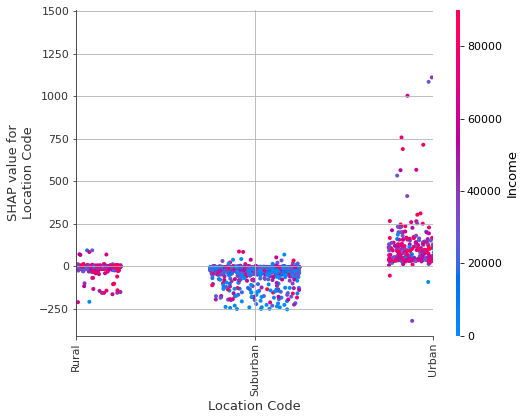

In [42]:
# show shap dependence plot for categorical features
X_test_invtrans = X_test.copy()
X_test_invtrans[cat_features] = enc.inverse_transform(X_test_invtrans[cat_features])
X_test_invtrans[numeric_features] = scaler.inverse_transform(X_test_invtrans[numeric_features])

for cf in cat_features:
  fig = plt.figure(figsize=(8, 6))
  ax = fig.gca()
  shap.dependence_plot(cf, 
                       shap_values = shap_values.values, 
                       features = X_test_invtrans,
                       x_jitter = .5,
                       xmin="percentile(10.0)",
                       xmax="percentile(90.0)", 
                       interaction_index='Income',
                       ax=ax,
                       show=False)
  ax.grid('on')

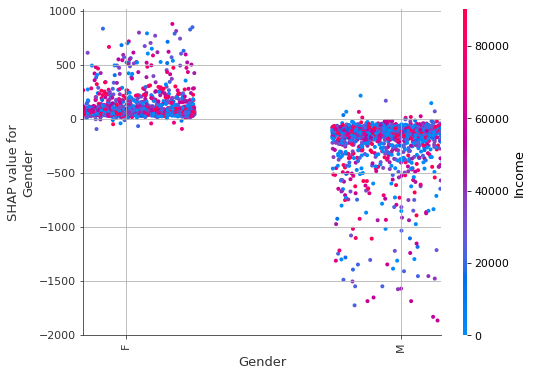

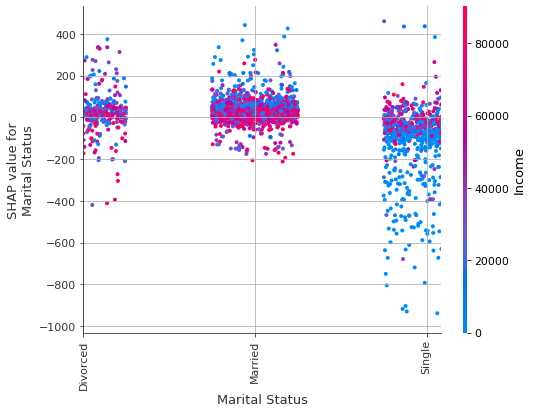

In [43]:
# show shap dependence plot for sensitive (categorical) features
X_test_invtrans = X_test.copy()
X_test_invtrans[cat_features] = enc.inverse_transform(X_test_invtrans[cat_features])
X_test_invtrans[numeric_features] = scaler.inverse_transform(X_test_invtrans[numeric_features])

for sf in sensitive_features:
  fig = plt.figure(figsize=(8, 6))
  ax = fig.gca()
  shap.dependence_plot(sf, 
                       shap_values = shap_values.values, 
                       features = X_test_invtrans,
                       x_jitter = .5,
                       xmin="percentile(10.0)",
                       xmax="percentile(90.0)", 
                       interaction_index='Income',
                       ax=ax,
                       show=False)
  ax.grid('on')

## Local Model Explanation

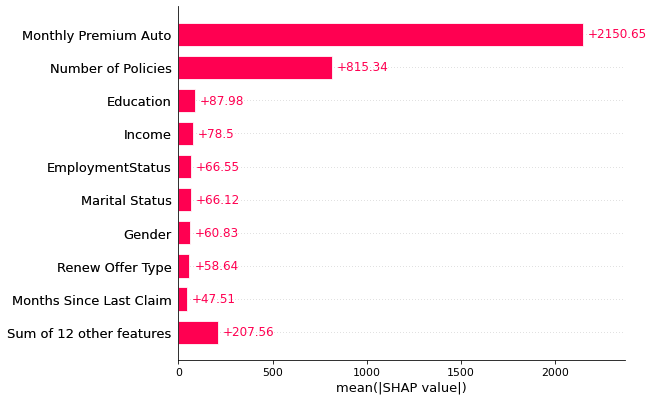

In [44]:
shap.plots.bar(shap_values[0:1])

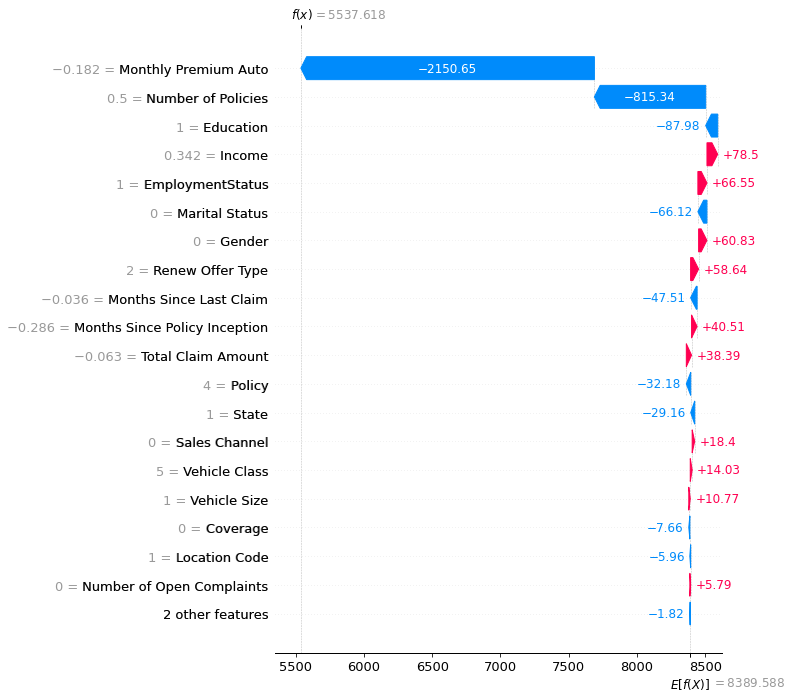

In [45]:
shap.plots.waterfall(shap_values[0], max_display=20)

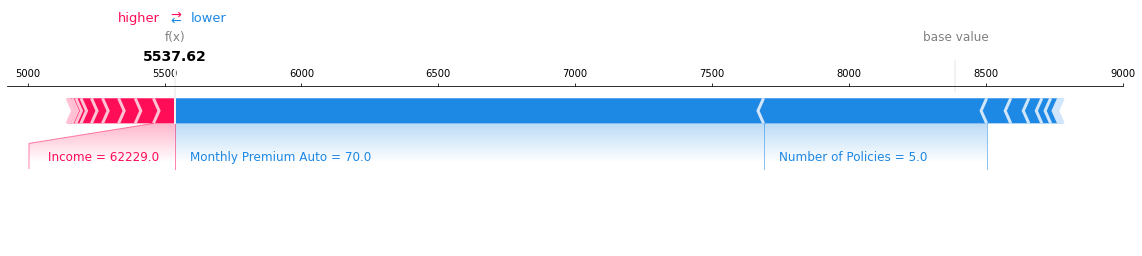

In [46]:
#shap.initjs()
X_test_invtrans = X_test.copy()
X_test_invtrans[cat_features] = enc.inverse_transform(X_test_invtrans[cat_features])
X_test_invtrans[numeric_features] = scaler.inverse_transform(X_test_invtrans[numeric_features])

shap.force_plot(base_value=shap_values.base_values[0], 
                shap_values= shap_values.values[0:1],
                features = X_test_invtrans[0:1], 
                matplotlib=True)

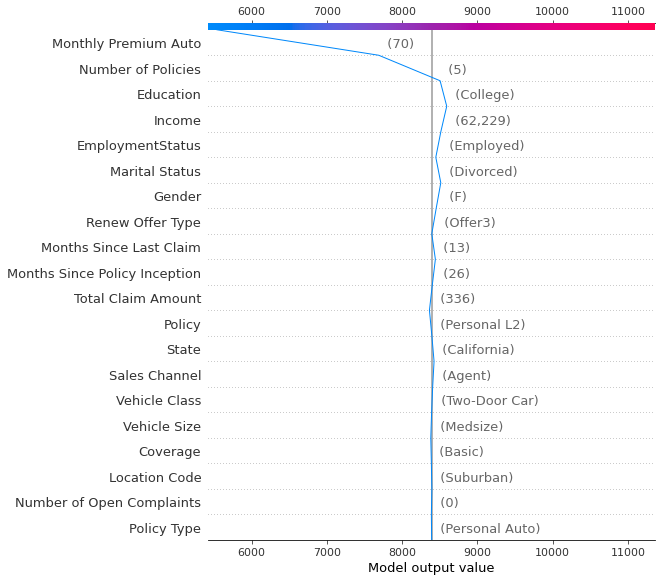

In [47]:
#shap.initjs()
X_test_invtrans = X_test.copy()
X_test_invtrans[cat_features] = enc.inverse_transform(X_test_invtrans[cat_features])
X_test_invtrans[numeric_features] = scaler.inverse_transform(X_test_invtrans[numeric_features])

shap.decision_plot(base_value=shap_values.base_values[0], 
                shap_values= shap_values.values[0:1],
                features = X_test_invtrans[0:1])

# Model Explainer Dashboard

In [48]:
tuned_model

LGBMRegressor(n_estimators=50, num_leaves=30)

In [49]:
explainer = RegressionExplainer(tuned_model, 
                                X_test, y_test,
                                shap='tree',
                                X_background=shap.sample(X_test, 50), 
                                precision='float32',
                                n_jobs=-1)
db = ExplainerDashboard(explainer)

Generating self.shap_explainer = shap.TreeExplainer(model, X_background)
Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating shap interaction values...
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Calculating dependencies...
Calculating importances...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...


In [50]:
db.to_yaml(DASHBOARDPATH / Path('dashboard_regression.yaml'), 
           explainerfile=Path('explainer_regression.joblib'), 
           dump_explainer=True)

Dumping configuration .yaml to /content/gdrive/MyDrive/Responsible_AI/Customer_LifeTime_Value/dashboard/dashboard_regression.yaml...
Dumping explainer to /content/gdrive/MyDrive/Responsible_AI/Customer_LifeTime_Value/dashboard/explainer_regression.joblib...


In [51]:
# Run Dashboard
db = ExplainerDashboard.from_config(DASHBOARDPATH / Path('explainer_regression.joblib'), 
                                    DASHBOARDPATH /  Path('dashboard_regression.yaml'))
db.run(host='0.0.0.0', port=9050, use_waitress=True)

Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating dependencies...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://172.28.0.2:9050
You can terminate the dashboard with ExplainerDashboard.terminate(9050)
Dash is running on http://127.0.0.1:9050/

Dash is running on http://127.0.0.1:9050/

Dash app running on:


<IPython.core.display.Javascript object>

# Make Inference Pipeline

[09:55:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(quantile_range=(10,
                                                                                                90)))]),
                                                  [0, 1, 2, 3, 4, 5, 6]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  array([ 7,  8,  9, 10, 11, 12, 13, 14,

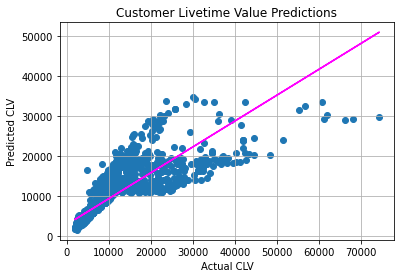

In [52]:
# Define preprocessing for numeric columns (scale them)
num_features = list(np.arange(0,7))
numeric_transformer = Pipeline(steps=[('scaler', RobustScaler(quantile_range=(10,90)))])

# Define preprocessing for categorical features (encode them)
categorical_features = np.arange(7,X.shape[1])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=True, drop='first', handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', XGBRegressor())])

model = pipeline.fit(X_train, y_train)
print(model)

# get predictions
predictions = model.predict(X_test)

# Evaluate the model using the test data
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Customer Livetime Value Predictions')

# overlay the regression line
z = np.polyfit(y_test.reshape(-1), predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.grid('on')
plt.show()

# Model Fairness

In [53]:
from fairlearn.metrics import selection_rate, MetricFrame

In [54]:
# Get metrics by sensitive group from fairlearn
print('\nMetrics by Group:')
metrics = {'R2': r2_score,
           'MSE': mean_squared_error}

group_metrics = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=model.predict(X_test),
                             sensitive_features=X_test[sensitive_features])

print(group_metrics.by_group)


Metrics by Group:
                             R2              MSE
Gender Marital Status                           
0.0    0.0             0.683774  20035758.278386
       1.0             0.708039   13551466.90259
       2.0             0.671898  13934172.882112
1.0    0.0             0.670378  15990720.843728
       1.0             0.679108  14342535.171703
       2.0             0.640918  18964305.260967


In [55]:
from raiwidgets import FairnessDashboard

# View this model in Fairlearn's fairness dashboard, and see the disparities which appear:
FairnessDashboard(sensitive_features=X_test[sensitive_features],
                   y_true=y_test,
                   y_pred={"CLV_model": model.predict(X_test)})

Output hidden; open in https://colab.research.google.com to view.

# ToDo

In [56]:
# pipeline verträgliches onehotencoding-------------ok
# danach pca
# erst verschiedene modelle testen und das beste hyperparameter tunen
# pipeline aufbauen
# explainability
# fairness